In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.image as mpimg
from typing import Optional
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from typing import Dict

In [2]:
DATA_PATH = '../data/img'
PLOT_PATH = './plots'

In [3]:
def display_images(path: str,
                   output: Optional[str] = None) -> None:
    """
    display randomly 3 images from 3 classes.
    @param {str} path - path to the folder containing the classes
    @param {str} output - path to save the image
    """
    
    classes = os.listdir(path)
    classes = random.sample(classes, 3)

    fig, axs = plt.subplots(3, 3, figsize=(10, 10))

    for i, class_ in enumerate(classes):
        images = os.listdir(os.path.join(path, class_))
        images = random.sample(images, 3)
        for j, image in enumerate(images):
            img = mpimg.imread(os.path.join(path, class_, image))
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(f'{class_} - {image}')
    if output:
        plt.savefig(output)
    plt.show()

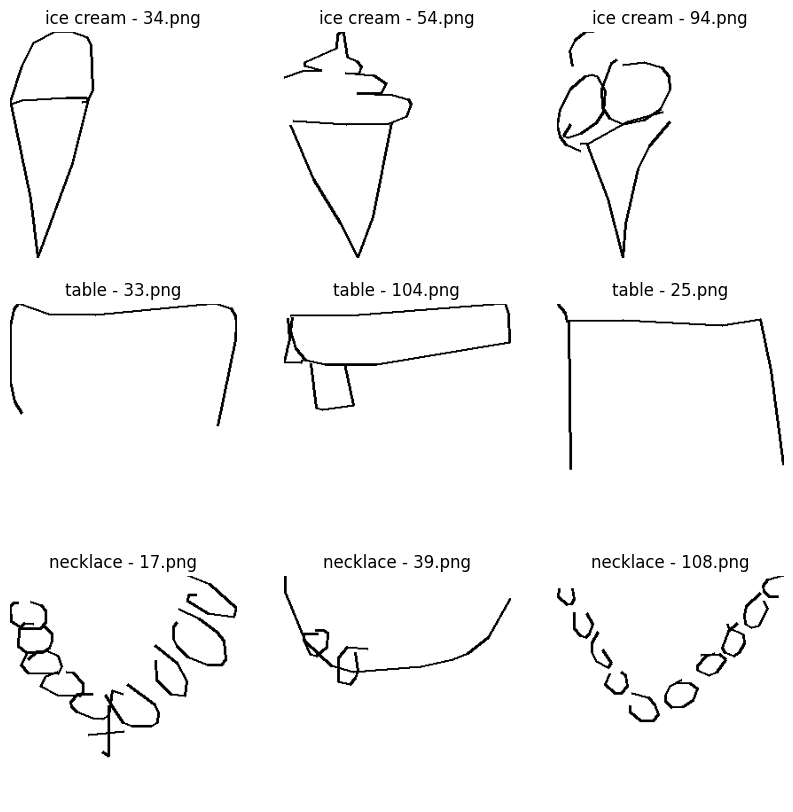

In [4]:
display_images(f"{DATA_PATH}/train")

In [5]:
def plot_images_distribution(path: str,
                             output: Optional[str] = None) -> None:
    """
    plot the distribution of the images in the classes.
    @param {str} path - path to the folder containing the classes
    @param {str} output - path to save the image
    """
    
    classes = os.listdir(path)
    images = [len(os.listdir(os.path.join(path, class_))) for class_ in classes
                if os.path.isdir(os.path.join(path, class_))]
    plt.figure(figsize=(10, 5))
    sns.barplot(x=classes, y=images)
    plt.xticks(rotation=45)
    plt.xlabel('Classes')
    plt.ylabel('Number of images')
    plt.title('Images distribution in the classes')
    if output:
        plt.savefig(output)
    plt.show()

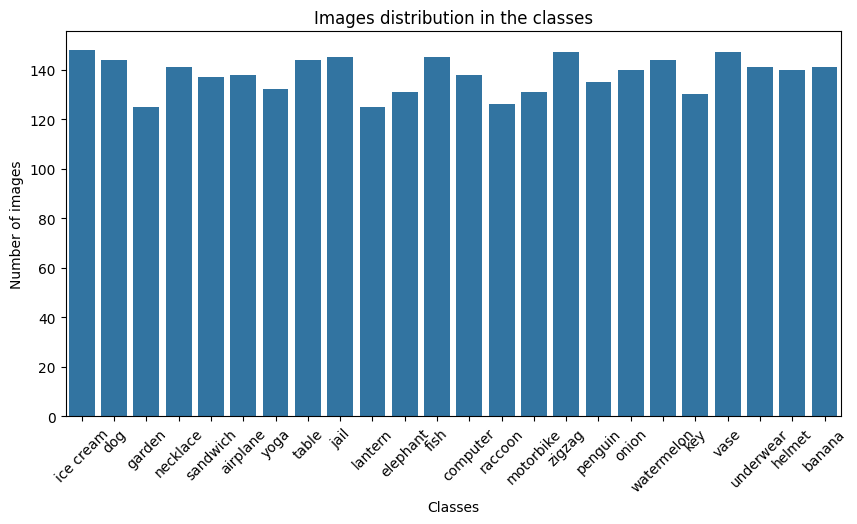

In [6]:
plot_images_distribution(f"{DATA_PATH}/train")

In [7]:
def get_images(path: str) -> dict:
    """
    get the images from the path and convert them to numpy arrays.
    @param {str} path - path to the folder containing the classes
    @return {dict} - dictionary with labels as keys and images as values
    """
    
    images = {}
    classes = os.listdir(path)
    for class_ in tqdm(classes):
        images[class_] = []
        for image in os.listdir(os.path.join(path, class_)):
            img = mpimg.imread(os.path.join(path, class_, image))
            img = np.transpose(img, (2, 0, 1))
            images[class_].append(img)
    return images

In [8]:
train_data = get_images(f"{DATA_PATH}/train")

  0%|          | 0/24 [00:00<?, ?it/s]

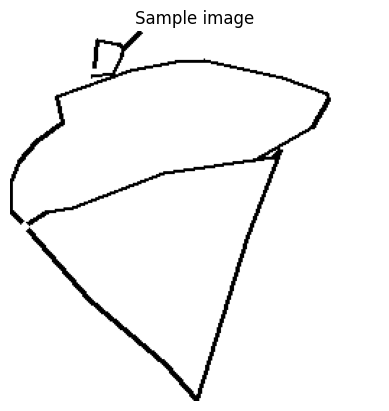

In [9]:
sample = train_data['ice cream'][0]
plt.imshow(sample.transpose(1, 2, 0))
plt.axis('off')
plt.title('Sample image')
plt.show()

In [10]:
train_data['ice cream'][0].shape

(3, 256, 256)

In [11]:
def load_train_val_test(path: str,
                        pandas: bool = True) -> dict:
    """
    load the train, validation and test data.
    @param {str} path - path to the folder containing the classes
    @return {dict} - dictionary with train, validation and test data
    """
    
    train = get_images(os.path.join(path, 'train'))
    val = get_images(os.path.join(path, 'val'))
    test = get_images(os.path.join(path, 'test'))

    if pandas:
        train = pd.DataFrame([(np.array(img), label) for label, images in train.items() for img in images],
                             columns=['image', 'label'])
        val = pd.DataFrame([(np.array(img), label) for label, images in val.items() for img in images],
                           columns=['image', 'label'])
        test = pd.DataFrame([(np.array(img), label) for label, images in test.items() for img in images],
                            columns=['image', 'label'])

    return {'train': train, 'val': val, 'test': test}

In [12]:
data_dict = load_train_val_test(DATA_PATH)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [13]:
data_dict['train'].head()

,image,label
0,"[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...",ice cream
1,"[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...",ice cream
2,"[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...",ice cream
3,"[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...",ice cream
4,"[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0...",ice cream


In [14]:
def flatten_images(data: dict) -> dict:
    """
    flatten the images in the data.
    @param {dict} data - dictionary with train, validation and test data
    @return {dict} - dictionary with flattened images
    """
    
    for key in data.keys():
        # apply mean between the channels
        data[key]['image'] = data[key]['image'].apply(lambda x: np.mean(x, axis=0))
        # flatten the image
        data[key]['image'] = data[key]['image'].apply(lambda x: x.flatten())
    return data

In [15]:
flattened_data = flatten_images(data_dict)

In [16]:
flattened_data['train'].head()

,image,label
0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",ice cream
1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",ice cream
2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",ice cream
3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",ice cream
4,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",ice cream


In [17]:
flattened_data['train'] = flattened_data['train'].sample(frac=1, random_state=42).reset_index(drop=True)

In [18]:
flattened_data['train'].head()

,image,label
0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",onion
1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",raccoon
2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",dog
3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",watermelon
4,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",table


In [19]:
flattened_data['train']['image'].shape

(3315,)

In [20]:
pca = PCA(n_components=3)
X = np.array(flattened_data['train']['image'].tolist())
X_std = StandardScaler().fit_transform(X)
X = pca.fit_transform(X_std)

In [21]:
df_pca = pd.DataFrame(X, columns=['PC1', 'PC2', 'PC3'])
df_pca['label'] = flattened_data['train']['label']
fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', color='label')
fig.show()

In [23]:
kmeans = KMeans(n_clusters=len(label2idx), random_state=42)
kmeans.fit(np.array(flattened_data['train']['image'].tolist()))

KMeans(n_clusters=24, random_state=42)

In [24]:
flattened_data['train']

,image,label
0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",onion
1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",raccoon
2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",dog
3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",watermelon
4,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",table
...,...,...
3310,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",table
3311,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",jail
3312,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",lantern
3313,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",yoga


In [25]:
# display the distribution of label for each cluster with a splited bar plot by label, in x axis the cluster and in y axis the number of images
def plot_cluster_distribution(data: pd.DataFrame,
                             kmeans: KMeans,
                             output: Optional[str] = None) -> pd.DataFrame:
        """
        plot the distribution of the labels in the clusters.
        @param {pd.DataFrame} data - data with the images and labels
        @param {KMeans} kmeans - kmeans model
        @param {str} output - path to save the image
        """
        # dont modify the original data

        df = data.copy()
        df['cluster'] = kmeans.labels_
        # new df grouped by cluster and count number of images by label
        df = df.groupby(['cluster', 'label']).size().reset_index(name='count')
        
        # dark background for plotly
        px.defaults.template = "plotly_dark"
        fig = px.bar(df, x='cluster', y='count', color='label', barmode='relative')
        fig.show()
        if output:
            fig.write_image(output)

        return df
        

In [26]:
df_grped = plot_cluster_distribution(flattened_data['train'], kmeans, f"{PLOT_PATH}/kmeans_cluster_distribution.png")

In [28]:
flattened_data['train'].head()

,image,label
0,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",onion
1,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",raccoon
2,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",dog
3,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",watermelon
4,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",table


In [29]:
label2idx = {label: idx for idx, label in enumerate(flattened_data['train']['label'].unique())}
idx2label = {idx: label for label, idx in label2idx.items()}

In [27]:
gnb = GaussianNB()

gnb.fit(flattened_data['train']['image'].tolist(), flattened_data['train']['label'])